In [2]:
import os
import sys
import time
import glob
import json
import numpy as np
import logging
import argparse

import matplotlib.pyplot as plt
import datetime
import pytz

import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々
import torch.backends.cudnn as cudnn

from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# utils

In [3]:
def dictspace(f):
  def inner(**kwds):
    return f(argparse.Namespace(**kwds))
  return inner

In [4]:
def dictspace_default(**kwds):
  def deco(f):
    def inner(**ikwds):
      kwds.update(ikwds)
      return f(argparse.Namespace(**kwds))
    return inner
  return deco

In [5]:
def accuracy(output, target, topk=(1,)):
  maxk = max(topk)
  batch_size = target.size(0)

  _, pred = output.topk(maxk, 1, True, True)
  pred = pred.t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))

  res = []
  for k in topk:
    correct_k = correct[:k].view(-1).float().sum(0)
    res.append(correct_k.mul_(100.0/batch_size))
  return res

In [6]:
class AvgrageMeter(object):

  def __init__(self):
    self.reset()

  def reset(self):
    self.avg = 0
    self.sum = 0
    self.cnt = 0

  def update(self, val, n=1):
    self.sum += val * n
    self.cnt += n
    self.avg = self.sum / self.cnt

In [7]:
def save_path(path):
  dt_now = datetime.datetime.now(pytz.timezone('Asia/Tokyo'))
  return '{}-{}'.format(path, dt_now.strftime('%Y-%m-%d_%H-%M-%S'))

In [8]:
def create_exp_dir(path, scripts_to_save=None):
  if not os.path.exists(path):
    os.mkdir(path)
  print('Experiment dir : {}'.format(path))

  if scripts_to_save is not None:
    os.mkdir(os.path.join(path, 'scripts'))
    for script in scripts_to_save:
      dst_file = os.path.join(path, 'scripts', os.path.basename(script))
      shutil.copyfile(script, dst_file)

In [9]:
def init_logging(save_path):
  class Formatter(logging.Formatter):
      """override logging.Formatter to use an aware datetime object"""
      def converter(self, timestamp):
          dt = datetime.datetime.fromtimestamp(timestamp)
          tzinfo = pytz.timezone('Asia/Tokyo')
          return tzinfo.localize(dt)
          
      def formatTime(self, record, datefmt=None):
          dt = self.converter(record.created)
          if datefmt:
              s = dt.strftime(datefmt)
          else:
              try:
                  s = dt.isoformat(timespec='milliseconds')
              except TypeError:
                  s = dt.isoformat()
          return s

  log_format = '%(asctime)s %(message)s'
  logging.basicConfig(stream=sys.stdout, level=logging.INFO,
      format=log_format, datefmt='%m/%d %I:%M:%S %p')
  fh = logging.FileHandler(os.path.join(save_path, 'log.txt'))
  fh.setFormatter(Formatter(log_format))
  logging.getLogger().addHandler(fh)

In [10]:
def set_seed(seed):
  np.random.seed(seed)
  # cudnn.benchmark = True
  torch.manual_seed(seed)
  # cudnn.enabled=True
  torch.cuda.manual_seed(seed)

In [11]:
def save_dir(dir : str, drivepath = './drive/My Drive/ml'):
  # TODO : init for mount drive
  
  if not dir: return

  import subprocess
  res = subprocess.run(["cp", "-r", "./" + dir, drivepath], stdout=subprocess.PIPE)
  sys.stdout.write(res.stdout)

In [12]:
class ConfusionMatrix():
  def __init__(self):
    pass
  
  # @torch.no_grad()
  # def run(self, model, dataloader):
  #   data, target = next(iter(dataloader))
  #   device = data.device
  #   num = target.max().long() + 1
  #   cm = torch.zeros(num, num).to(device)

  #   for i, (data, target) in enumerate(dataloader):
  #     data = data.to(device)
  #     target = target.to(device)
  #     outputs = model(data)
  #     _, preds = torch.max(outputs, 1)
  #     for t, p in zip(target.view(-1), preds.view(-1)):
  #       cm[t.long(), p.long()] += 1

  #   self.matrix = cm
  #   self.dim = num
  #   self.sum0 = self.matrix.sum(0)
  #   self.sum1 = self.matrix.sum(1)
  #   self.sum = self.matrix.sum()
  #   return cm

In [13]:
class Metrics():
  def __init__(self, model, dataloader):
    self._run(model, dataloader)
    self.epsilon = 1e-7
  
  @torch.no_grad()
  def _run(self, model, dataloader):
    data, target = next(iter(dataloader))
    device =  next(model.parameters()).device
    print(device)
    num = target.max().long() + 1
    cm = torch.zeros(num, num).to(device)

    for i, (data, target) in enumerate(dataloader):
      data = data.to(device)
      target = target.to(device)
      outputs = model(data)
      _, preds = torch.max(outputs, 1)
      for t, p in zip(target.view(-1), preds.view(-1)):
        cm[t.long(), p.long()] += 1

    self.matrix = cm
    self.dim = num
    self.sum0 = self.matrix.sum(0)
    self.sum1 = self.matrix.sum(1)
    self.sum = self.matrix.sum()

  def confusion_matrix(self):
    return self.matrix

  def TP(self, index):
    return self.matrix[index][index]

  def FN(self, index):
    return self.sum1[index] - self.TP(index)

  def FP(self, index):
    return self.sum0[index] - self.TP(index)

  def TN(self, index):
    return self.sum - self.TP(index) - self.FN(index) - self.FP(index)

  def _sum(self, F):
    return sum(F(i) for i in range(self.dim))
    
  def _micro(self, F, G):
    return self._sum(F) / (self._sum(F) + self._sum(G) + self.epsilon)

  def _macro(self, F, G):
    return sum(F(i) / (F(i) + G(i) + self.epsilon) for i in range(self.dim)) / self.dim

  def _switch(self, F, G, micro):
    return (self._micro(F, G) if micro else self._macro(F, G))

  def accuracy(self, micro=True):
    return (self._sum(self.TP) / self.sum if micro else 
            (sum(self.TP(i) / self.sum1 for i in range(self.dim)) / self.dim).mean())

  def precision(self, micro=True):
    return self._switch(self.TP, self.FP, micro)

  def recall(self, micro=True):
    return self._switch(self.TP, self.FN, micro)

  def specificity(self, micro=True):
    return self._switch(self.TN, self.FP, micro)

  def f_measure(self, micro=True):
    p, r = self.precision(micro), self.recall(micro)
    return 2 * p * r / (p + r + self.epsilon)

  def print(self):
    print(self.confusion_matrix())
    print("accuracy ", self.accuracy(), self.accuracy(micro=False))
    print("precision ", self.precision(), self.precision(micro=False))
    print("recall ", self.recall(), self.recall(micro=False))
    print("specificity ", self.specificity(), self.specificity(micro=False))
    print("f_measure ", self.f_measure(), self.f_measure(micro=False))

In [14]:
class Store():
  def __init__(self, dir="result", name="log", fig=[]):
    self.dict = {}
    self.dir = dir
    self.name = name
    self.fig = fig
  
  def add(self, name, value):
    if not name in self.dict:
      self.dict[name] = []
    self.dict[name].append(value)
  
  def save(self):
    self.save_log()
    for metrix, x, y in self.fig:
      self.save_fig(metrix, x, y)

  def save_log(self, name=None):
    name = name if name else self.name
    path = os.path.join(self.dir, name + ".txt")
    with open(path, mode='w') as f:
      f.write("%s" % self.dict)

  def save_fig(self, metrix, xlabel, ylabel, show=True):
    fig = plt.figure()

    if type(metrix) is str:
      times = len(self.dict[metrix])
      plt.plot(np.arange(times), self.dict[metrix])
    else :
      times = len(self.dict[metrix[0]])
      for m in metrix:
        plt.plot(np.arange(times), self.dict[m], label=m)
      metrix = "_".join(metrix)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    if show: plt.show()
    fig.savefig(os.path.join(self.dir, "%s_%d.png" % (metrix, times)))

  def __repr__(self):
    return "store in %s" % self.dict

# model

In [15]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [16]:
class Shortcut(nn.Module):
  def __init__(self, in_channel, out_channel, stride):
    super(Shortcut, self).__init__()
    self.f = self._shortcut(in_channel, out_channel, stride)

  def forward(self, x):
    return self.f(x)

  def _shortcut(self, channel_in, channel_out, stride):
    if channel_in != channel_out or stride > 1:
      return nn.Conv2d(channel_in, channel_out, 
                       kernel_size=1, stride=stride, padding=0)
    else:
      return lambda x: x

In [17]:
class Block(nn.Module):
  def __init__(self, index, in_channel, out_channel, stride, shortcuts):
    super(Block, self).__init__()
    self.conv = nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1)
    self.bn = nn.BatchNorm2d(out_channel)
    self.relu = nn.ReLU(inplace=True)
    self.stride = stride
    if stride: self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.shortcuts = self._make_shortcuts(shortcuts)
    self.enable = len(self.shortcuts) > 0
    self.index = index
    self.connection = [i for i, _, _, _ in shortcuts]

  def _make_shortcuts(self, shortcuts):
    layers = nn.ModuleList()
    for (index, i, o, s) in shortcuts:
      layers += [Shortcut(i, o, s)]
    return layers

  def forward(self, x, xs, alpha):
    output = self.bn(self.conv(x))

    if self.enable:
      # shortcut
      cut = sum(alpha[i] * F(xs[i]) for i, F in enumerate(self.shortcuts))
      output = output + cut
    
    output = self.relu(output)

    if self.stride:
      output = self.pool(output)

    return output

In [89]:
class Network(nn.Module):
  def __init__(self, gene):
    super(Network, self).__init__()
    self.gene = gene
    self.blocks = self._make_blocks(gene)
    self.pool = nn.AvgPool2d(kernel_size=1, stride=1)
    self.classifier = nn.Linear(512, 10)

  def _decode_gene(self, gene):
    ch, st = [], []
    for g in gene:
      if g == 'M':
        st[-1] *= 2
      else :
        ch += [g]
        st += [1]
    return ch, st

  def _make_blocks(self, gene):
    channel, stride = self._decode_gene(gene)
    s_stride = self.__pi(stride)
    blocks = nn.ModuleList()
    in_channel = 3
    for i, (c, s) in enumerate(zip(channel, stride)):
      setting = []
      for j in range(i-1):
        setting += [(j, channel[j], c, int(s_stride[i-1] / s_stride[j]))]
      blocks += [Block(i, in_channel, c, s>1, setting)]
      in_channel = c
    return blocks

  def _init_alpha(self, blocks, device, delta=1e-3):
    alpha = []

    for block in blocks:
      a = delta * torch.randn(len(block.connection))
      alpha += [torch.tensor(a, requires_grad=True, device=device)]

    return alpha
  
  def init_alpha(self, device):
    self.alphas = self._init_alpha(self.blocks, device)
    return self

  def __pi(self, array):
    r = []
    s = 1
    for q in array:
      s *= q
      r += [s]
    return r

  def forward(self, x):
    state = []

    for idx, block in enumerate(self.blocks):
      xs = [state[i] for i in block.connection]
      x = block(x, xs, F.softmax(self.alphas[idx], dim=0))
      state += [x]

    out = self.pool(x)
    out = out.view(out.size(0), -1)
    out = self.classifier(out)
    return out

  @torch.no_grad()
  def alpha_tensor(self, softmax=True):
    alpha = torch.zeros(len(self.alphas), max([len(a) for a in self.alphas]))
    for i, a in enumerate(self.alphas):
      alpha[i, :len(a)] = F.softmax(a, dim=0) if softmax else a
    return alpha

  # def to(self, *args, **kwargs):
  #   with torch.no_grad():
  #     for idx, alpha in enumerate(self.alphas):
  #       self.alphas[idx] = alpha.to(*args, **kwargs)
  #   return super(Network, self).to(*args, **kwargs)

In [46]:
class Architect():
  def __init__(self, valid_loader, model, criterion, lr, device):
    self.valid_loader = valid_loader
    self.model = model
    self.criterion = criterion
    self.optimizer = optim.Adam(model.alphas, lr=lr, betas=(0.5, 0.999), weight_decay=1e-3)
    self.device = device

  def step(self):
    data_v, target_v = next(iter(self.valid_loader))
    data_v, target_v = data_v.to(self.device), target_v.to(self.device)

    self.optimizer.zero_grad()
    output = self.model(data_v)
    loss = self.criterion(output, target_v)
    loss.backward()
    self.optimizer.step()

In [20]:
def load_dataset(train=2000, test=500, valid=0):
  #画像の変形処理
  transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
  ])

  transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
  ])

  dataset = torchvision.datasets.CIFAR10
  kwargs = {"root" : "./data", "download" : True}

  #CIFAR-10のtrain, testsetのロード
  trainset = dataset(train=True, transform=transform, **kwargs)
  testset = dataset(train=False, transform=transform_test, **kwargs)
  
  trainset, validset, _ = torch.utils.data.random_split(trainset, [train, valid, 50000-train-valid])
  testset, _ = torch.utils.data.random_split(testset, [test, 10000-test])
  return argparse.Namespace(train=trainset, test=testset, valid=validset)

# learning

In [21]:
@dictspace_default(retain_graph=True)
def train(args):
  objs = AvgrageMeter()
  top1 = AvgrageMeter()
  top5 = AvgrageMeter()
  args.model.train()

  for step, (input, target) in enumerate(args.dataset):
    n = input.size(0)

    input = Variable(input, requires_grad=False).to(args.device)
    target = Variable(target, requires_grad=False).to(args.device)

    args.architect.step()

    args.optimizer.zero_grad()
    logits = args.model(input)
    loss = args.criterion(logits, target)

    loss.backward(retain_graph=args.retain_graph)
    # nn.utils.clip_grad_norm(model.parameters(), args.grad_clip)
    args.optimizer.step()

    prec1, prec5 = accuracy(logits, target, topk=(1, 5))
    objs.update(loss.item(), n)
    top1.update(prec1.item(), n)
    top5.update(prec5.item(), n)

    if step % args.report_freq == 0:
      logging.info('train %03d %e %f %f', step, objs.avg, top1.avg, top5.avg)

  return top1.avg, objs.avg

In [22]:
@dictspace
def infer(args):
  objs = AvgrageMeter()
  top1 = AvgrageMeter()
  top5 = AvgrageMeter()
  args.model.eval()

  for step, (input, target) in enumerate(args.dataset):
    input = Variable(input, requires_grad=False).to(args.device)
    target = Variable(target, requires_grad=False).to(args.device)

    logits = args.model(input)
    loss = args.criterion(logits, target)

    prec1, prec5 = accuracy(logits, target, topk=(1, 5))
    n = input.size(0)
    objs.update(loss.item(), n)
    top1.update(prec1.item(), n)
    top5.update(prec5.item(), n)

    if step % args.report_freq == 0:
      logging.info('valid %03d %e %f %f', step, objs.avg, top1.avg, top5.avg)

  return top1.avg, objs.avg

In [95]:
@dictspace
def learning(args):

  # log init
  fig = [(["train_acc", "test_acc"], "epochs", "accuracy[%]"),
         (["train_loss", "test_loss"], "epochs", "loss")]
  store = Store(dir=args.save, name="store", fig=fig)
  store.add("kwargs", args)

  # cuda init
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  set_seed(args.seed)

  # model setup
  gene = cfg['VGG11']
  logging.info('gene %s', gene)
  model = args.model(gene).to(device).init_alpha(device)

  if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

  kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
  sets = load_dataset(train=args.train_size, test=args.test_size, valid=args.train_size)
  trainloader = torch.utils.data.DataLoader(sets.train, batch_size=args.batch_size, shuffle=True, **kwargs)
  validloader = torch.utils.data.DataLoader(sets.valid, batch_size=args.batch_size, shuffle=True, **kwargs)
  testloader = torch.utils.data.DataLoader(sets.test, batch_size=args.batch_size, shuffle=False, **kwargs)
  
  optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=5e-4)
  criterion = nn.CrossEntropyLoss()
  architect = Architect(validloader, model, criterion, args.lr_alpha, device)


  for epoch in range(args.epochs):
    logging.info('epoch %d', epoch)
    # print("grad", model.alphas[0].requires_grad)
    logging.info('alpha %s', model.alpha_tensor())
    logging.info('alpha %s', model.alpha_tensor(softmax=False))

    # training
    train_acc, train_obj = train(dataset=trainloader, model=model, 
                                 criterion=criterion, optimizer=optimizer, 
                                 architect=architect, 
                                 device=device, report_freq=args.report)
    logging.info('train_acc %f', train_acc)
    store.add("train_loss", train_obj)
    store.add("train_acc", train_acc)

    # validation
    valid_acc, valid_obj = infer(dataset=testloader, model=model, 
                                 criterion=criterion,
                                 device=device, report_freq=args.report)
    logging.info('valid_acc %f', valid_acc)
    store.add("test_loss", valid_obj)
    store.add("test_acc", valid_acc)

    if epoch % args.checkpoint == 0:
      store.save()
      save_dir(args.save)

  store.save()
  save_dir(args.save)

# main

In [24]:
@dictspace
def main(args):
  args.save = save_path(args.save)
  create_exp_dir(args.save, scripts_to_save=glob.glob('*.py'))
  init_logging(args.save)

  learning(**vars(args))

Experiment dir : exp-2020-09-10_21-33-24
09/10 12:33:24 PM gene [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Files already downloaded and verified
Files already downloaded and verified
09/10 12:33:26 PM epoch 0
09/10 12:33:26 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5003, 0.4997, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3337, 0.3327, 0.3336, 0.0000, 0.0000, 0.0000],
        [0.2497, 0.2501, 0.2503, 0.2499, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2002, 0.1998, 0.2000, 0.0000],
        [0.1667, 0.1665, 0.1668, 0.1666, 0.1665, 0.1669]])
09/10 12:33:26 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 3.9149e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 7.9818e-04, -2.8706e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00

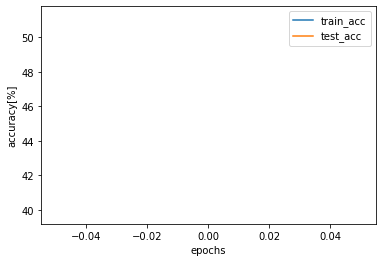

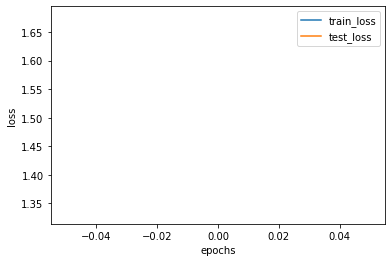

09/10 12:34:49 PM epoch 1
09/10 12:34:49 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4538, 0.5462, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3437, 0.3181, 0.3382, 0.0000, 0.0000, 0.0000],
        [0.2102, 0.2409, 0.2623, 0.2865, 0.0000, 0.0000],
        [0.1655, 0.2107, 0.1754, 0.2571, 0.1913, 0.0000],
        [0.0937, 0.1189, 0.1450, 0.2875, 0.2847, 0.0701]])
09/10 12:34:49 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 2.7501e-16,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-9.2407e-02,  9.2745e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 3.2998e-02, -4.4524e-02,  1.6948e-02,  0.0000e+00,  0.0000e+00,

Traceback (most recent call last):


09/10 12:41:22 PM train 300 7.008171e-01 75.840947 98.323297
09/10 12:41:40 PM train_acc 76.052000
09/10 12:41:40 PM valid 000 7.141026e-01 76.562500 98.437500
09/10 12:41:42 PM valid_acc 73.840000
09/10 12:41:42 PM epoch 6
09/10 12:41:42 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3064, 0.6936, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2563, 0.3846, 0.3591, 0.0000, 0.0000, 0.0000],
        [0.2024, 0.2316, 0.2105, 0.3556, 0.0000, 0.0000],
        [0.1677, 0.1986, 0.1917, 0.2179, 0.2242, 0.0000],
        [0.0578, 0.0643, 0.0641, 0.5389, 0.2374, 0.0374]])
09/10 12:41:42 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 7.4362e-27,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e

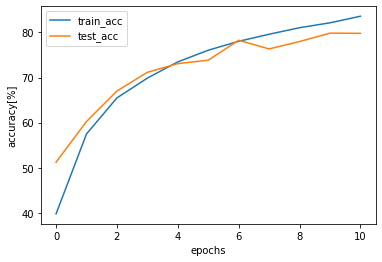

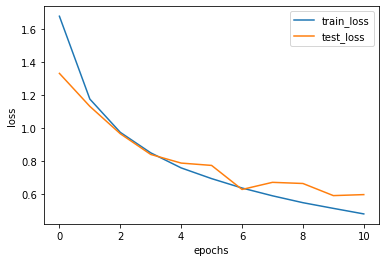

09/10 12:48:34 PM epoch 11
09/10 12:48:34 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5388, 0.4612, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2849, 0.4278, 0.2873, 0.0000, 0.0000, 0.0000],
        [0.2087, 0.2331, 0.1703, 0.3880, 0.0000, 0.0000],
        [0.1512, 0.2456, 0.1987, 0.2241, 0.1804, 0.0000],
        [0.0318, 0.0375, 0.0309, 0.7716, 0.1157, 0.0125]])
09/10 12:48:34 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.1491e-43,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 7.7853e-02, -7.7827e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-1.4435e-01,  2.6226e-01, -1.3610e-01,  0.0000e+00,  0.0000e+00

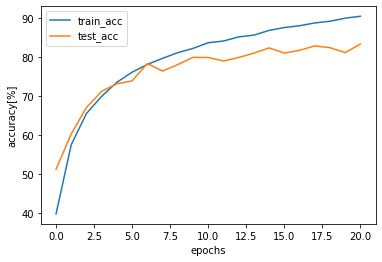

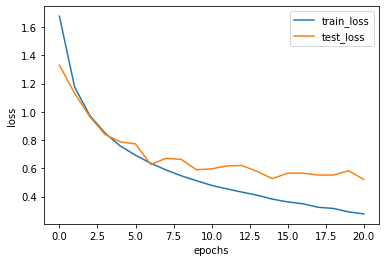

09/10 01:02:23 PM epoch 21
09/10 01:02:23 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8565, 0.1435, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1103, 0.7699, 0.1198, 0.0000, 0.0000, 0.0000],
        [0.1692, 0.4301, 0.1428, 0.2578, 0.0000, 0.0000],
        [0.1054, 0.4893, 0.1274, 0.1401, 0.1379, 0.0000],
        [0.0176, 0.0203, 0.0161, 0.9200, 0.0185, 0.0076]])
09/10 01:02:23 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.1491e-43,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 8.9311e-01, -8.9310e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-6.8930e-01,  1.2538e+00, -6.0701e-01,  0.0000e+00,  0.0000e+00

Traceback (most recent call last):


09/10 01:03:05 PM train 200 2.696231e-01 90.757152 99.735697
09/10 01:03:26 PM train 300 2.722091e-01 90.656146 99.730066
09/10 01:03:45 PM train_acc 90.560000
09/10 01:03:45 PM valid 000 3.418863e-01 87.500000 100.000000
09/10 01:03:46 PM valid_acc 83.180000
09/10 01:03:46 PM epoch 22
09/10 01:03:46 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8666, 0.1334, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0994, 0.7946, 0.1059, 0.0000, 0.0000, 0.0000],
        [0.1395, 0.5445, 0.1194, 0.1966, 0.0000, 0.0000],
        [0.0850, 0.5969, 0.0958, 0.1230, 0.0994, 0.0000],
        [0.0162, 0.0193, 0.0148, 0.9256, 0.0171, 0.0070]])
09/10 01:03:46 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
      

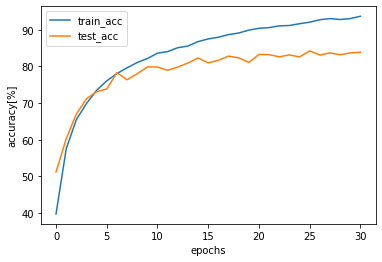

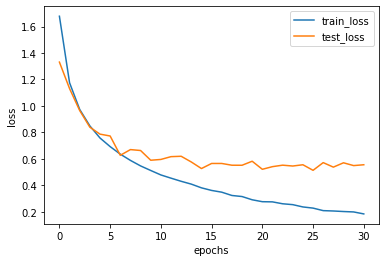

09/10 01:16:26 PM epoch 31
09/10 01:16:26 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7353, 0.2647, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1205, 0.7412, 0.1382, 0.0000, 0.0000, 0.0000],
        [0.0757, 0.7576, 0.0749, 0.0918, 0.0000, 0.0000],
        [0.0583, 0.7359, 0.0661, 0.0710, 0.0687, 0.0000],
        [0.0192, 0.0228, 0.0186, 0.9104, 0.0199, 0.0091]])
09/10 01:16:27 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.1491e-43,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 5.1078e-01, -5.1077e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-6.1737e-01,  1.1989e+00, -4.8053e-01,  0.0000e+00,  0.0000e+00

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])


09/10 01:26:35 PM train 100 1.300608e-01 95.420792 99.953589
09/10 01:26:56 PM train 200 1.282994e-01 95.374689 99.976679
09/10 01:27:18 PM train 300 1.387368e-01 95.021802 99.974045
09/10 01:27:37 PM train_acc 95.012000
09/10 01:27:37 PM valid 000 5.239930e-01 89.062500 100.000000
09/10 01:27:38 PM valid_acc 84.640000
09/10 01:27:38 PM epoch 39
09/10 01:27:38 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6562, 0.3438, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1320, 0.7183, 0.1497, 0.0000, 0.0000, 0.0000],
        [0.0473, 0.8582, 0.0443, 0.0501, 0.0000, 0.0000],
        [0.0481, 0.7921, 0.0521, 0.0548, 0.0529, 0.0000],
        [0.0239, 0.0286, 0.0215, 0.8938, 0.0227, 0.0095]])
09/10 01:27:38 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000

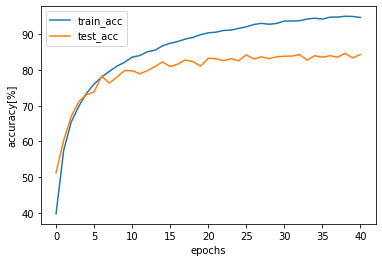

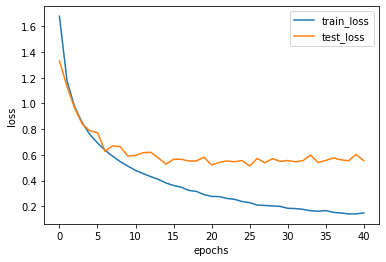

09/10 01:30:28 PM epoch 41
09/10 01:30:28 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6778, 0.3222, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1536, 0.6734, 0.1729, 0.0000, 0.0000, 0.0000],
        [0.0527, 0.8445, 0.0480, 0.0547, 0.0000, 0.0000],
        [0.0516, 0.7791, 0.0559, 0.0573, 0.0562, 0.0000],
        [0.0264, 0.0315, 0.0246, 0.8804, 0.0263, 0.0108]])
09/10 01:30:28 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.1491e-43,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 3.7183e-01, -3.7183e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-4.9520e-01,  9.8260e-01, -3.7691e-01,  0.0000e+00,  0.0000e+00

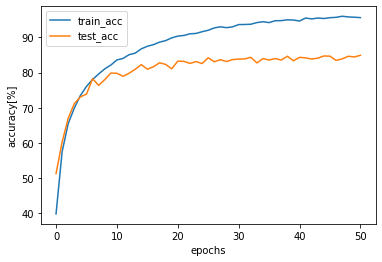

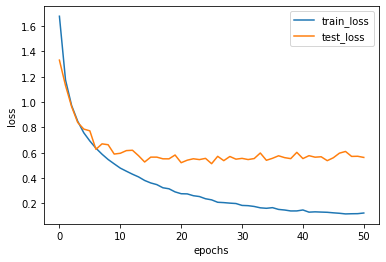

09/10 01:44:32 PM epoch 51
09/10 01:44:32 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6453, 0.3547, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2714, 0.3899, 0.3387, 0.0000, 0.0000, 0.0000],
        [0.0491, 0.8569, 0.0455, 0.0484, 0.0000, 0.0000],
        [0.0400, 0.8312, 0.0422, 0.0437, 0.0429, 0.0000],
        [0.0361, 0.0520, 0.0347, 0.8255, 0.0379, 0.0138]])
09/10 01:44:32 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.1491e-43,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 2.9930e-01, -2.9930e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-7.9413e-02,  2.8279e-01,  1.4225e-01,  0.0000e+00,  0.0000e+00

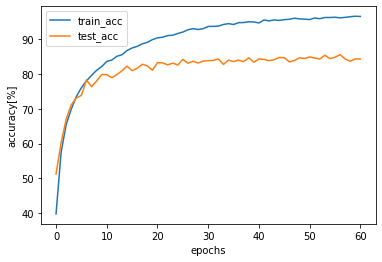

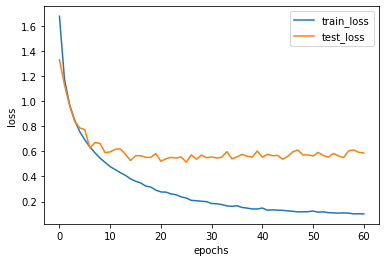

09/10 01:58:25 PM epoch 61
09/10 01:58:25 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5463, 0.4537, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2509, 0.2842, 0.4649, 0.0000, 0.0000, 0.0000],
        [0.0376, 0.8879, 0.0357, 0.0388, 0.0000, 0.0000],
        [0.0392, 0.8389, 0.0400, 0.0418, 0.0402, 0.0000],
        [0.0549, 0.0797, 0.0512, 0.7418, 0.0530, 0.0193]])
09/10 01:58:25 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.1491e-43,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 9.2923e-02, -9.2923e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-1.9775e-01, -7.3071e-02,  4.1892e-01,  0.0000e+00,  0.0000e+00

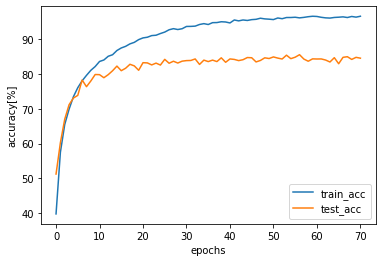

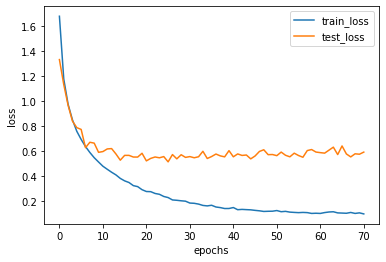

09/10 02:12:17 PM epoch 71
09/10 02:12:17 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2876, 0.7124, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1837, 0.1169, 0.6994, 0.0000, 0.0000, 0.0000],
        [0.0568, 0.8311, 0.0540, 0.0581, 0.0000, 0.0000],
        [0.0458, 0.8072, 0.0484, 0.0501, 0.0485, 0.0000],
        [0.0971, 0.1368, 0.0917, 0.5471, 0.0972, 0.0301]])
09/10 02:12:17 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.1491e-43,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-4.5359e-01,  4.5359e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-2.8488e-01, -7.3677e-01,  1.0520e+00,  0.0000e+00,  0.0000e+00

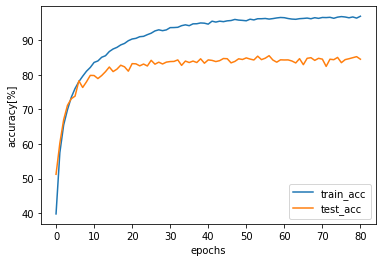

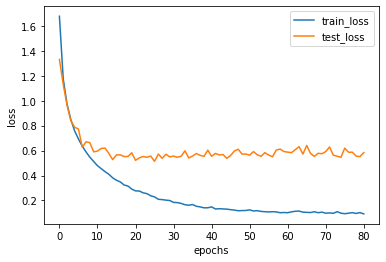

09/10 02:26:04 PM epoch 81
09/10 02:26:04 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2595, 0.7405, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2212, 0.1154, 0.6634, 0.0000, 0.0000, 0.0000],
        [0.0525, 0.8399, 0.0523, 0.0553, 0.0000, 0.0000],
        [0.0423, 0.8251, 0.0436, 0.0452, 0.0437, 0.0000],
        [0.1373, 0.1686, 0.1608, 0.3219, 0.1715, 0.0398]])
09/10 02:26:04 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.1491e-43,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-5.2422e-01,  5.2422e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-1.3669e-01, -7.8714e-01,  9.6185e-01,  0.0000e+00,  0.0000e+00

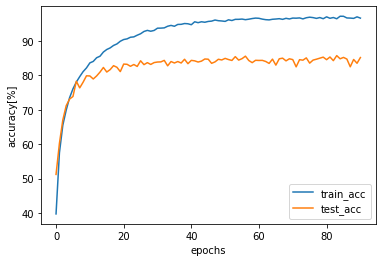

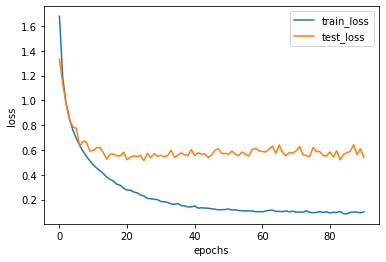

09/10 02:39:51 PM epoch 91
09/10 02:39:51 PM alpha tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2464, 0.7536, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2241, 0.1206, 0.6553, 0.0000, 0.0000, 0.0000],
        [0.0535, 0.8350, 0.0540, 0.0575, 0.0000, 0.0000],
        [0.0377, 0.8420, 0.0396, 0.0411, 0.0396, 0.0000],
        [0.1340, 0.1529, 0.2065, 0.2254, 0.2374, 0.0439]])
09/10 02:39:51 PM alpha tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.1491e-43,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-5.5898e-01,  5.5898e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-1.4665e-01, -7.6625e-01,  9.2632e-01,  0.0000e+00,  0.0000e+00

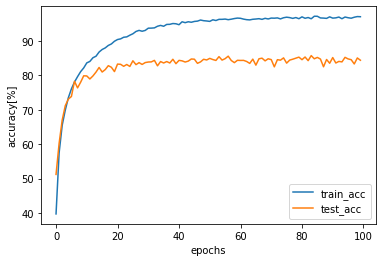

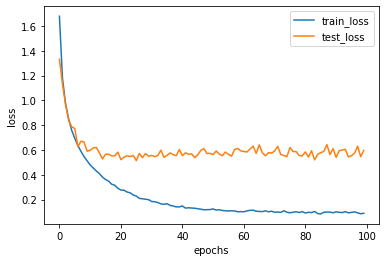

In [96]:
if __name__ == '__main__':
  main(save="exp", model=Network, lr=0.01, momentum=0.9, lr_alpha=0.005,
       train_size=25000, test_size=5000, batch_size=64, epochs=100, seed=41, 
       report=100, checkpoint=10)

# exp

TODO
- google drive mount
- F1 Score
- Transfar learning
- decorate injection
- save model, checkpoint
- log store
- watch model size, memory
- early stopping

In [ ]:
class F1_Loss(nn.Module):
    '''Calculate F1 score. Can work with gpu tensors
    
    The original implmentation is written by Michal Haltuf on Kaggle.
    
    Returns
    -------
    torch.Tensor
        `ndim` == 1. epsilon <= val <= 1
    
    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    - http://www.ryanzhang.info/python/writing-your-own-loss-function-module-for-pytorch/
    '''
    def __init__(self, epsilon=1e-7):
        super().__init__()
        self.epsilon = epsilon
        
    def forward(self, y_pred, y_true,):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, 2).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)
        
        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2* (precision*recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1-self.epsilon)
        return 1 - f1.mean()

In [ ]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = CNN9()

sets = load_dataset()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
testloader = torch.utils.data.DataLoader(sets.test, batch_size=64, **kwargs)

F1_Loss()(model, testloader)

In [ ]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = CNN9()

sets = load_dataset()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
testloader = torch.utils.data.DataLoader(sets.test, batch_size=64, **kwargs)

ConfusionMatrix().run(model, testloader)

In [ ]:
p =torch.arange(0, 5) % 3
print(p)
F.one_hot(p, 10)